In [2]:
%reload_ext autoreload
%autoreload 2


In [3]:
from gensim.models import KeyedVectors
model_word2vec = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

import gensim.downloader as api
model_glove = api.load('glove-wiki-gigaword-300')


In [10]:
# import gensim.downloader as api
# 
# # Get information about all available models
# info = api.info()
# 
# # Print the names of all available models
# print("Available models:")
# for model_name in info['models']:
#     print(model_name)

Available models:
fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


In [4]:
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
# nltk.download('punkt')
import string

stop_words = set(stopwords.words('english'))


def wordList_from_sentence(sentence):
    tokens = word_tokenize(sentence.lower())
    # Filter out puncts and common stopwords
    cleaned_tokens = [word for word in tokens if word.lower() not in stop_words and word not in string.punctuation]
    return cleaned_tokens

def vector_from_wordlist(wordList,model):
    vectors = [model[word] for word in wordList if word in model]
    sentence_vector = np.mean(vectors, axis=0)
    return  sentence_vector

def vector_from_sentence(sentence,model):
    return vector_from_wordlist(wordList_from_sentence(sentence.lower()),model);


In [6]:
wordList_from_sentence("Scissors are resting on a roll of clear tape.")

['scissors', 'resting', 'roll', 'clear', 'tape']

In [5]:
from sklearn.metrics.pairwise import cosine_similarity

def similarity_score(vec1,vec2):
    similarity = cosine_similarity([vec1], [vec2])[0][0]
    return similarity


def get_similarity_matrix(sentences,model):
    n = len(sentences)
    similarity_matrix = np.zeros((n,n))
    
    for i in range(n):
        for j in range(n):
            si_vec = vector_from_sentence(sentences[i],model)
            sj_vec = vector_from_sentence(sentences[j],model)
            try:
                similarity_matrix[i][j] = similarity_score(si_vec,sj_vec)
            except:
                print(sentences[i],sentences[j])
    
    return similarity_matrix


In [11]:
# MMR_SCORE = LMD * REL_SCORE - ( 1 - LMD ) * MAX*SIM

def MMR_score (target, sentences, vec_model, lambda_value = 0.5):
    scores= []
    if isinstance(target, str):  
        target = wordList_from_sentence(target)
        
    target_vector = vector_from_wordlist(target, vec_model)
    
    for sentence in sentences:
        sentence_vector = vector_from_wordlist(wordList_from_sentence(sentence), vec_model)
        
        
        rel_score = similarity_score(target_vector, sentence_vector)        
        max_sim_score  = max([similarity_score(sentence_vector,vector_from_sentence(s,model)) for s in sentences if s != sentence],default=0);
        
        mmr_score = (lambda_value * rel_score)  - ((1-lambda_value) * max_sim_score)
        
        scores.append((sentence,rel_score,max_sim_score,mmr_score))
    
    return  scores
    

In [18]:
# MMR_SCORE = LMD * REL_SCORE - ( 1 - LMD ) * MAX*SIM

def MMR_score_cache_max (target, sentences, vec_model,image_id, sim_matrix, lambda_value = 0.5):
    scores= []
    if isinstance(target, str):  
        target = wordList_from_sentence(target)
        
    target_vector = vector_from_wordlist(target, vec_model)
    
    for i,sentence in enumerate(sentences):
        sentence_vector = vector_from_wordlist(wordList_from_sentence(sentence), vec_model)
        
        rel_score = similarity_score(target_vector, sentence_vector)        
                
        sentence_similarties = sim_matrix[i,:]
        sentence_similarties_without_i = np.delete(sentence_similarties,i)
        max_sim_score = np.max(sentence_similarties_without_i)
        mmr_score = (lambda_value * rel_score)  - ((1-lambda_value) * max_sim_score)
        
        scores.append((sentence,image_id[i],rel_score,max_sim_score,mmr_score))
    
    return  scores


In [19]:
def MMR_score_cache_average (target, sentences, vec_model,image_id, sim_matrix, lambda_value = 0.5):
    scores= []
    if isinstance(target, str):
        target = wordList_from_sentence(target)

    target_vector = vector_from_wordlist(target, vec_model)

    for i,sentence in enumerate(sentences):
        sentence_vector = vector_from_wordlist(wordList_from_sentence(sentence), model)

        rel_score = similarity_score(target_vector, sentence_vector)

        sentence_similarties = sim_matrix[i,:]
        sentence_similarties_without_i = np.delete(sentence_similarties,i)
        max_sim_score = np.mean(sentence_similarties_without_i)
        mmr_score = (lambda_value * rel_score)  - ((1-lambda_value) * max_sim_score)

        scores.append((sentence,image_id[i],rel_score,max_sim_score,mmr_score))

    return  scores

In [20]:
# MMR_SCORE = LMD * REL_SCORE - ( 1 - LMD ) * MAX*SIM

def MMR_score_iterative(target, sentences, vec_model, lambda_value=0.5):
    scores = []
    remaining_sentences = sentences.copy()

    if isinstance(target, str):  
        target = wordList_from_sentence(target)
    target_vector = vector_from_wordlist(target, vec_model)

    while remaining_sentences:
        max_mmr_score = float('-inf')
        best_sentence = None
        best_rel_score = 0
        best_max_sim_score = 0

        for sentence in remaining_sentences:
            sentence_vector = vector_from_wordlist(wordList_from_sentence(sentence), vec_model)
            rel_score = similarity_score(target_vector, sentence_vector)
            max_sim_score = max([similarity_score(sentence_vector, vector_from_wordlist(wordList_from_sentence(s), vec_model)) for s in remaining_sentences if s != sentence], default=0)
            mmr_score = (lambda_value * rel_score) - ((1 - lambda_value) * max_sim_score)

            if mmr_score > max_mmr_score:
                max_mmr_score = mmr_score
                best_sentence = sentence
                best_rel_score = rel_score
                best_max_sim_score = max_sim_score

        scores.append((best_sentence, best_rel_score, best_max_sim_score, max_mmr_score))
        remaining_sentences.remove(best_sentence)

    return scores



$$
\text{MMR} = \arg\max_{D_i \in R} \left[ \lambda \times \text{Sim}_1(D_i, Q) - (1-\lambda) \times \max_{D_j \in R, j \neq i} \text{Sim}_2(D_i, D_j) \right]
$$

Where:
- \(D_i\): Candidate document
- \(R\): Set of all retrievable documents
- \(Q\): Query
- \(\lambda\): A parameter to balance relevance and diversity \( (0 \leq \lambda \leq 1) \)
- \(\text{Sim}_1\), \(\text{Sim}_2\): Similarity measures

In [8]:
# Load all metadata from images
from json_getter import extract_names_from_json
sentences = extract_names_from_json("val2017/jsonAnnotation.json")


In [73]:
top_7

[['A group of young men playing a game of basketball.', 481390],
 ['An upscale living area containing white and glass furniture with brown accents.',
  572678],
 ['A bear sitting in the grass surrounded by five vultures.', 229997],
 ['a balloon elephant sits in the middle of a park area ', 325031],
 ['Horses are standing in an open field in the grass.', 298697],
 ['Two street signs are sitting on top of the pole', 259854],
 ['A lady explains the process of milking a cow.', 114907]]

In [72]:
import random

copy_list = sentences.copy()
random.shuffle(copy_list)
top_7 = copy_list[:7]

top_7

from operator import itemgetter

top_5_sen = list(map(itemgetter(0), top_7))
top_5_sen


['A group of young men playing a game of basketball.',
 'An upscale living area containing white and glass furniture with brown accents.',
 'A bear sitting in the grass surrounded by five vultures.',
 'a balloon elephant sits in the middle of a park area ',
 'Horses are standing in an open field in the grass.',
 'Two street signs are sitting on top of the pole',
 'A lady explains the process of milking a cow.']

In [48]:
from operator import itemgetter
sen_list = list(map(itemgetter(0), sentences))
id_list = list(map(itemgetter(1), sentences))

In [76]:
test_sen = ['Several people playing tennis in a school gymnasium.',
 'a person in a wheel chair swinging a tennis racket.',
 'A giraffe eating some leaves from a tree at the zoo. ',
 'A couple of adult elephants with a baby one following along.',
'A group of young men playing a game of basketball.',
 'a small pony a with two smaller ponies standing in front of it', 
 'A bird sits on a parking meter with several parked cars in the street.']


In [77]:
# USE THIS TO GENERATE SIMMATRIX
similarity_matrix = get_similarity_matrix(test_sen,model_word2vec)
np.savetxt("Sim_matrix_word2vec_test.csv", similarity_matrix, delimiter=",", fmt="%.6f")
similarity_matrix = get_similarity_matrix(test_sen,model_glove)
np.savetxt("Sim_matrix_glove_test.csv", similarity_matrix, delimiter=",", fmt="%.6f")


In [72]:
from play_yolov8 import predict_img
import cv2
all_data,img = predict_img()
predictions = [data[1] for data in all_data]
predictions = list(dict.fromkeys(predictions))
target_word = predictions
target_word

Selected File: D:\python_land\ifn712_playground\dog.webp



0: 384x640 1 person, 1 dog, 724.4ms
Speed: 1.4ms preprocess, 724.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


['person', 'dog']

In [95]:
target_word = ["cooking"]

In [96]:
# CHANGE MODEL HERE
# model = model_glove 
# similarity_matrix =  np.loadtxt("Sim_matrix_glove.csv", delimiter=",")

model = model_word2vec
similarity_matrix =  np.loadtxt("Sim_matrix_word2vec.csv", delimiter=",")

#LAMBDA VALUE CHANGE HERE
lambda_value = 1


# # MAXIMUM METHOD
mmr_score_list = MMR_score_cache_max(target=target_word,sentences=sen_list,image_id=id_list,vec_model=model,sim_matrix=similarity_matrix,lambda_value=lambda_value)

# AVERAGE METHOD
# mmr_score_list = MMR_score_cache_average(target=target_word,sentences=sen_list,image_id=id_list,vec_model=model,sim_matrix=similarity_matrix,lambda_value=lambda_value)

sorted_mmr_score = sorted(mmr_score_list,key=lambda x : x[4],reverse=True)

In [97]:
sorted_mmr_score[0:40]

[('a wok on a stove cooking some food',
  455267,
  0.8308534,
  0.895532,
  0.8308534026145935),
 ('An elderly person in a kitchen cooking food.',
  281032,
  0.7492138,
  0.805108,
  0.7492138147354126),
 ('A dog eyeballing something cooking in the oven.',
  236592,
  0.6978187,
  0.769774,
  0.6978186964988708),
 ('Someone is cooking a vegtable stir fry for dinner',
  308430,
  0.68066543,
  0.6724,
  0.6806654334068298),
 ('a stove that has some food on it',
  410487,
  0.6563911,
  0.895532,
  0.6563910841941833),
 ('a stove with a tea kettle and cooking pot on top',
  136466,
  0.65372527,
  0.816306,
  0.653725266456604),
 ('There is some food in the baking pan on the counter.',
  165831,
  0.6527977,
  0.734977,
  0.6527976989746094),
 ('A white kitchen sink filled with dishes and eating utensils.',
  239627,
  0.650797,
  0.796472,
  0.6507970094680786),
 ('Person cooking an eggs on a black pot on a stove. ',
  580294,
  0.6495344,
  0.816306,
  0.6495344042778015),
 ('A buffe

In [98]:
from operator import itemgetter
show_list = list(map(itemgetter(1), sorted_mmr_score))
show_list= show_list[0:40]
print(show_list)

[455267, 281032, 236592, 308430, 410487, 136466, 165831, 239627, 580294, 419653, 322163, 258883, 45728, 384661, 455597, 365766, 30213, 512929, 294350, 802, 33638, 66231, 292060, 222825, 175364, 424721, 301718, 300233, 522007, 426253, 78266, 407960, 97022, 382696, 280918, 226130, 571893, 290768, 280930, 491216]


In [99]:
image_dir = 'val2017/val2017'
path_list = []
for id in show_list:
    image_path =  image_dir+  f"/{id:012d}.jpg"
    path_list.append(image_path)

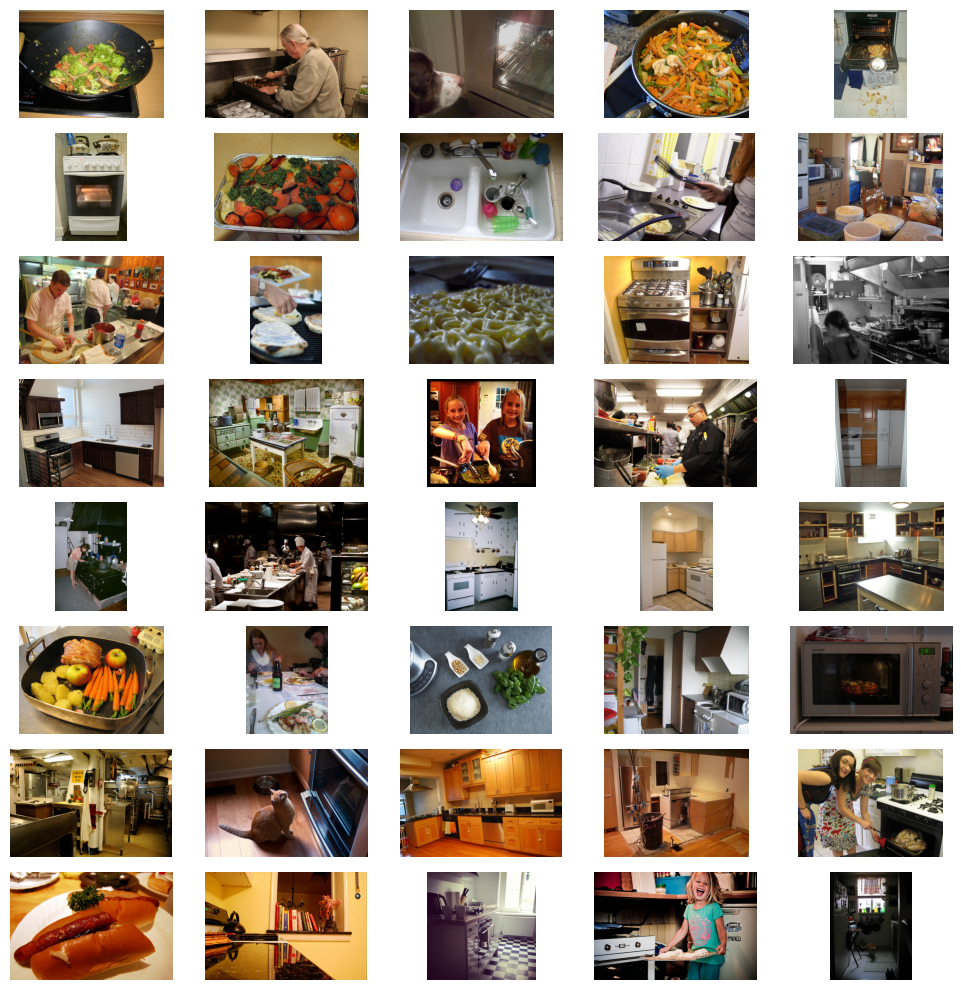

In [100]:
from imageshower import  show_images
show_images(path_list,8)